<h2 align=center> Facial Expression Recognition</h2>

In [1]:
!git clone https://github.com/nikzagarwal/Face-Emotion-Detection.git


Cloning into 'Face-Emotion-Detection'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 34102 (delta 0), reused 4 (delta 0), pack-reused 34094
Receiving objects: 100% (34102/34102), 121.69 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (35924/35924), done.


In [2]:
cd Face-Emotion-Detection

/content/Face-Emotion-Detection


### Task 1: Import Libraries

In [ ]:
pip install livelossplot

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG19

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


### Task 2: Plot Sample Images

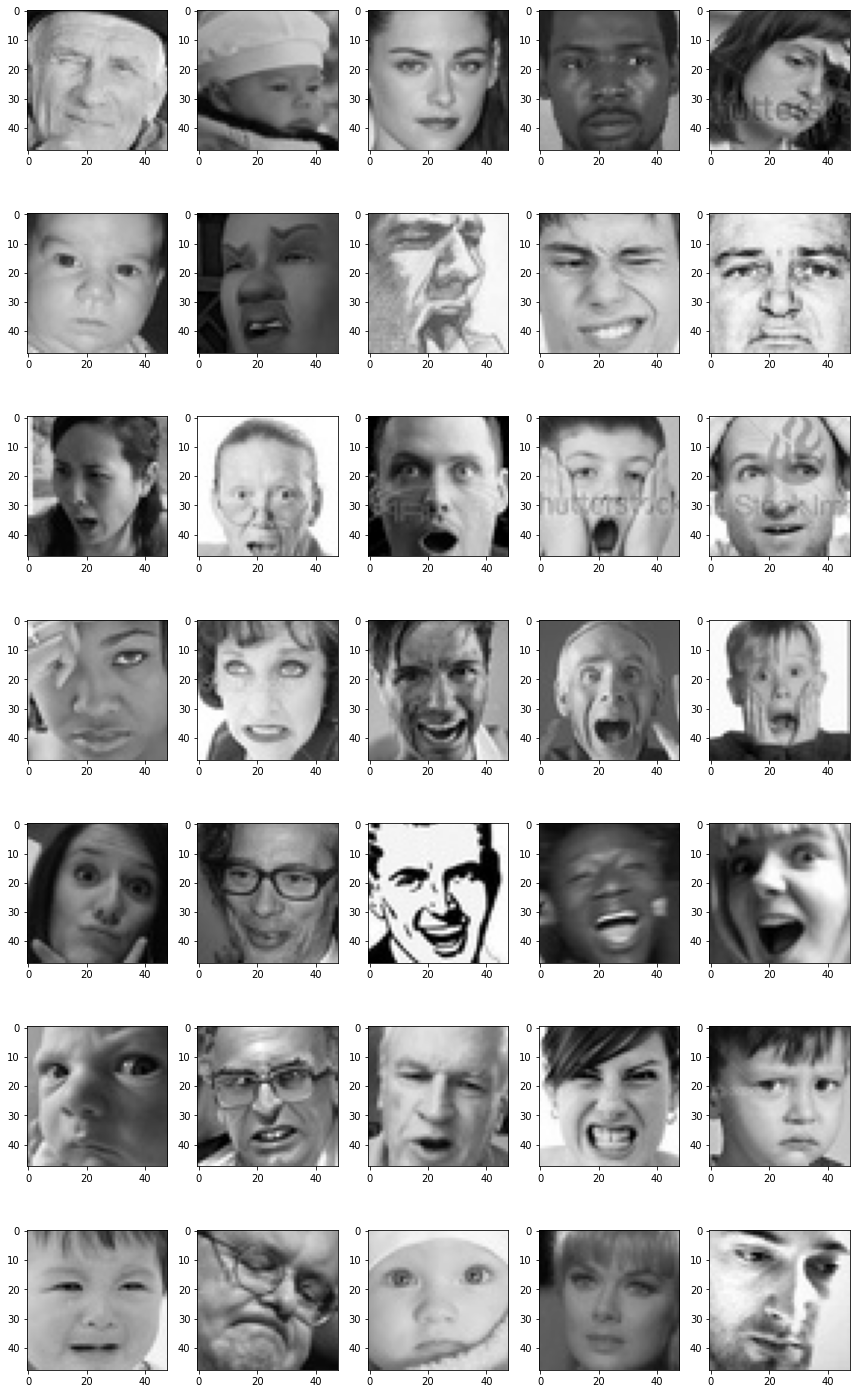

In [6]:
utils.datasets.fer.plot_example_images(plt).show()

In [7]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

4965 neutral images
436 disgust images
3171 surprise images
4097 fear images
7214 happy images
3995 angry images
4830 sad images


### Task 3: Generate Training and Validation Batches

In [8]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Task 4: Create CNN Model

### 1st model direct implementation of resnet50( training parameters again only using the architecture)

In [24]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights='imagenet',pooling='avg')

In [25]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [26]:
model = Sequential([
  Conv2D(3,(3,3), padding='same', input_shape=(48, 48,1)),
  base_model,
  Dense(7, activation='softmax'),
])
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 3)         30        
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 14343     
Total params: 23,602,085
Trainable params: 23,548,965
Non-trainable params: 53,120
_________________________________________________________________


### 2. Transfer model2 (keeping few layers of resnet50 and training rest of them again)

In [28]:
base_model2 = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights='imagenet')

In [30]:
base_model2.get_layer('conv1_conv').trainable = False
base_model2.get_layer('conv1_bn').trainable = False
base_model2.get_layer('conv2_block1_1_conv').trainable = False
base_model2.get_layer('conv2_block1_2_conv').trainable = False
base_model2.get_layer('conv2_block1_0_conv').trainable = False
base_model2.get_layer('conv2_block1_3_conv').trainable = False
base_model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
model2 = Sequential([
  Conv2D(3,(3,3), padding='same', input_shape=(48, 48,1)),
  base_model2,
  Flatten(),
  Dense(1024, activation='relu'),
  Dense(128, activation='relu'),
  Dense(7, activation='softmax'),
])
opt = Adam(lr=0.0005)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 3)         30        
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_12 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 903       
Total params: 32,109,477
Trainable params: 31,972,389
Non-trainable params: 137,088
____________________________________

### 3. We can also make our own model (just for illustration )

In [16]:
# Initialising the CNN
model3 = Sequential()

# 1 - Convolution
model3.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# 2nd Convolution layer
model3.add(Conv2D(128,(5,5), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# 3rd Convolution layer
model3.add(Conv2D(512,(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# 4th Convolution layer
model3.add(Conv2D(512,(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# Flattening
model3.add(Flatten())

# Fully connected layer 1st layer
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

# Fully connected layer 2nd layer
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)      

### Task 6: Train and Evaluate Model



### 1. This is on transferred model1 

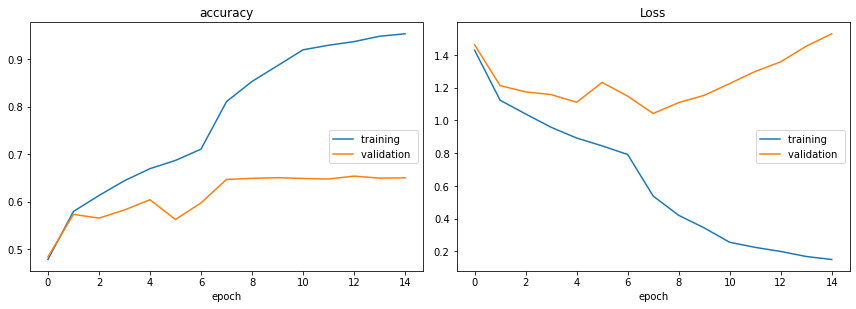

accuracy
	training         	 (min:    0.478, max:    0.954, cur:    0.954)
	validation       	 (min:    0.483, max:    0.654, cur:    0.650)
Loss
	training         	 (min:    0.150, max:    1.430, cur:    0.150)
	validation       	 (min:    1.043, max:    1.530, cur:    1.530)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 80s 180ms/step - loss: 0.1501 - accuracy: 0.9536 - val_loss: 1.5300 - val_accuracy: 0.6500 - lr: 1.0000e-05
CPU times: user 16min 19s, sys: 3min 58s, total: 20min 18s
Wall time: 20min 23s


In [133]:
%%time

epochs = 25
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights1.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## 2. This is on transferred model 2

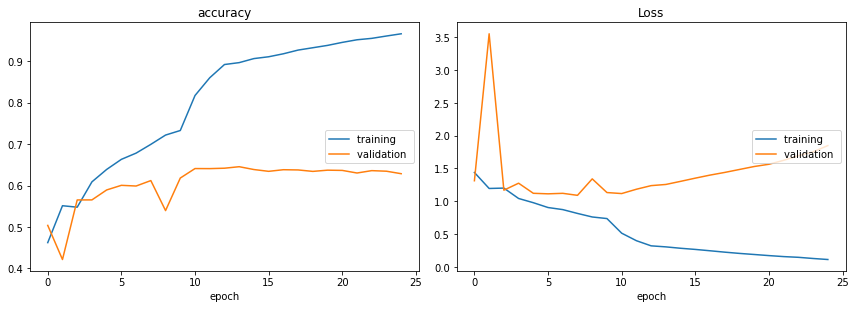

accuracy
	training         	 (min:    0.462, max:    0.966, cur:    0.966)
	validation       	 (min:    0.421, max:    0.645, cur:    0.628)
Loss
	training         	 (min:    0.113, max:    1.439, cur:    0.113)
	validation       	 (min:    1.091, max:    3.552, cur:    1.849)

Epoch 00025: saving model to model_weights2.h5
448/448 [==============================] - 82s 183ms/step - loss: 0.1132 - accuracy: 0.9661 - val_loss: 1.8490 - val_accuracy: 0.6285 - lr: 1.0000e-05
CPU times: user 26min 32s, sys: 7min 7s, total: 33min 39s
Wall time: 34min 32s


In [32]:
%%time

epochs = 25
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model2.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## 3. This is on self made model 3

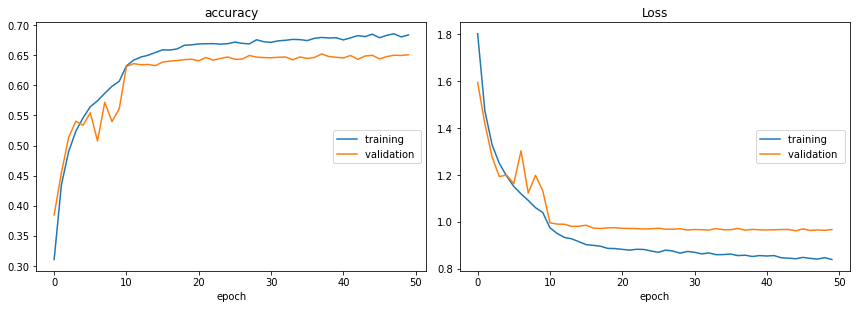

accuracy
	training         	 (min:    0.310, max:    0.686, cur:    0.684)
	validation       	 (min:    0.385, max:    0.652, cur:    0.651)
Loss
	training         	 (min:    0.839, max:    1.802, cur:    0.839)
	validation       	 (min:    0.961, max:    1.594, cur:    0.967)

Epoch 00050: saving model to model_weights3.h5
448/448 [==============================] - 28s 63ms/step - loss: 0.8390 - accuracy: 0.6839 - val_loss: 0.9670 - val_accuracy: 0.6509 - lr: 1.0000e-05
CPU times: user 23min 59s, sys: 5min 9s, total: 29min 8s
Wall time: 23min 40s


In [18]:
%%time

epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights3.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model3.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Task 7: Represent Model as JSON String

In [134]:
#model1
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

In [33]:
#model2
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)

In [21]:
#model3
model3_json = model3.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model3_json)